In [44]:
import sys

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from signifikante.algo import grnboost2_fdr, grnboost2, diy, genie3
import numpy as np
import scanpy as sc
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import numpy as np


import pingouin
import itertools
import random


In [45]:

from compute_networks import *

In [ ]:
net_collect = {}
p_net_collect = {}
groundtruth_collector = {}
metrics_collector = []
for s in ['5_sources', '10_sources', '20_sources']:
    os.makedirs(f'/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/{s}', exist_ok=True)
    net_collect[s] = []
    p_net_collect[s] = []
    groundtruth_collector[s] = []
    for i in range(1, 11):
        # Load expression matrix - in this case simulate one.
        groundtruth = pd.read_csv(f'/data/bionets/og86asub/SignifiKANTE_Results/data/sc_simulated_data/{s}/nets/network_{i}.tsv',  sep='\t')
        groundtruth_collector[s].append(groundtruth)
        tfs = list(groundtruth.source.unique())
        fdr_net = pd.read_csv(f'/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/{s}/grn_{i}.tsv', sep='\t')
        print(f'/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/{s}/grn_{i}.tsv')
        p_net_collect[s].append(fdr_net)
        metrics = compute_metrics(fdr_net, fdr_net, groundtruth, data_trial = f'data_{i}')
        metrics['data_configuration'] = s
        metrics_collector.append(metrics)

metrics_collector = pd.concat(metrics_collector)
metrics_collector.to_csv(f'/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/aggregated_metrics.tsv', sep = '\t', index=False)


/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_1.tsv
[1, 2, 5, 8, 11, 13, 16, 19, 22, 24, 27, 41, 55, 138, 207, 276]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_2.tsv
[1, 2, 4, 7, 9, 12, 14, 17, 19, 22, 24, 36, 49, 122, 183, 245]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_3.tsv
[0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 29, 39, 97, 146, 195]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_4.tsv
[2, 5, 10, 16, 21, 27, 32, 38, 43, 49, 54, 81, 109, 272, 408, 545]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_5.tsv
[2, 5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 89, 119, 297, 446, 595]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/5_sources/grn_6.tsv
[3, 6, 13, 20, 27, 34, 41, 48, 55, 62, 69, 104, 139, 347, 521, 695]
/data/bionets/og86asub/SignifiKANTE_Results/results/sc_simulated_data/

<Axes: xlabel='importance'>

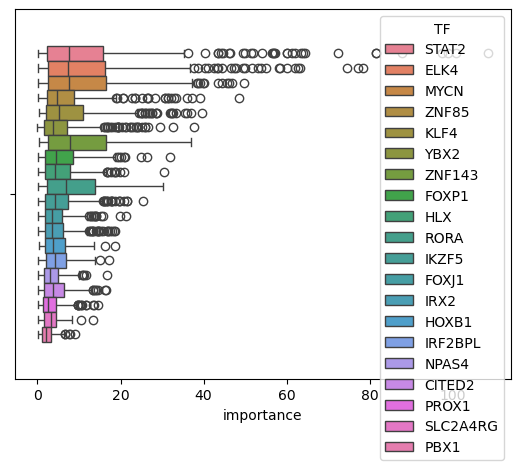

In [48]:
sns.boxplot(fdr_net, x='importance' , hue='TF')

<Axes: xlabel='pvalue'>

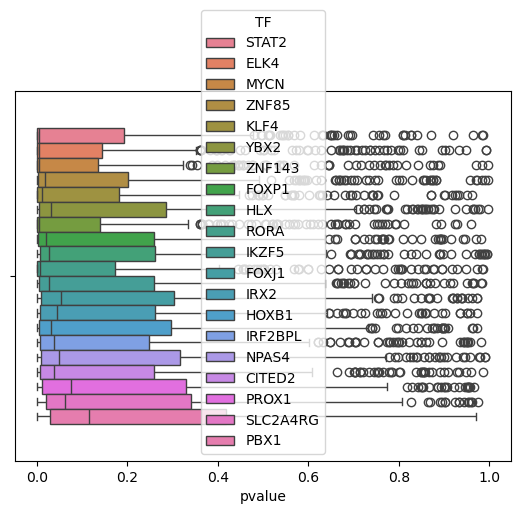

In [49]:
sns.boxplot(fdr_net, x='pvalue' , hue='TF')

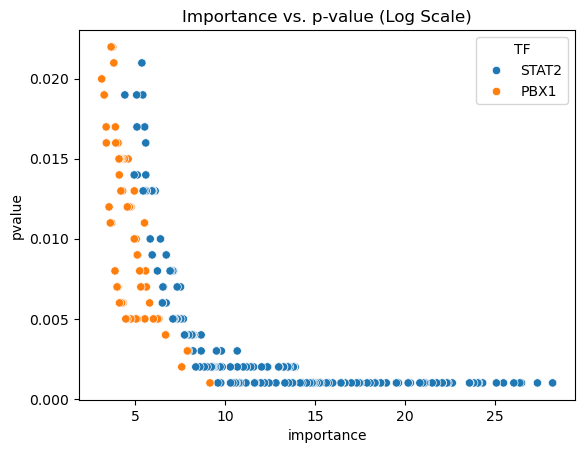

In [60]:

sns.scatterplot(
    data=fdr_net[ (fdr_net.p_adj<0.05) & (fdr_net.importance<30) & (fdr_net.TF.isin(['STAT2', 'PBX1'])) ],
    x='importance',
    y='pvalue',
    hue='TF'
)



# Optional: Set a title and show the plot
plt.title('Importance vs. p-value (Log Scale)')
plt.show()

In [75]:
metrics_collector

,Top N Predictions,thresholds,True Positives,Precision,Recall,comparison,dataset,data_configuration
0,1,0.500,0,0.000,0.000,GRNBoost2,data_1,5_sources
1,1,0.500,0,0.000,0.000,SignifiKANTE,data_1,5_sources
2,1,0.500,0,0.000,0.000,SignifiKANTE (BH),data_1,5_sources
3,2,1.000,0,0.000,0.000,GRNBoost2,data_1,5_sources
4,2,1.000,0,0.000,0.000,SignifiKANTE,data_1,5_sources
...,...,...,...,...,...,...,...,...
43,4782,75.000,201,0.056,0.663,SignifiKANTE,data_10,20_sources
44,4782,75.000,178,0.059,0.587,SignifiKANTE (BH),data_10,20_sources
45,6377,100.000,303,0.048,1.000,GRNBoost2,data_10,20_sources
46,6377,100.000,201,0.056,0.663,SignifiKANTE,data_10,20_sources


In [78]:
metrics_collector['combined_hue'] = metrics_collector['comparison'] 

<Axes: xlabel='thresholds', ylabel='Precision'>

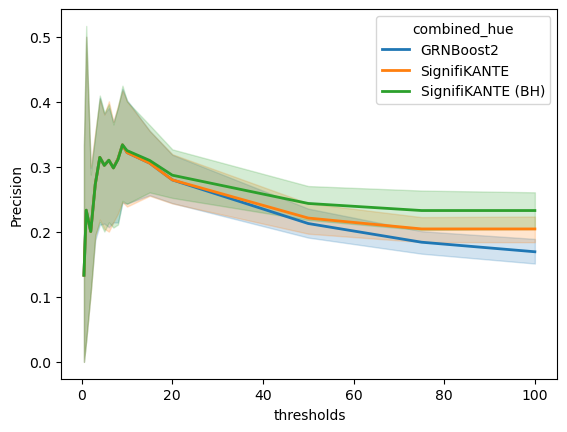

In [83]:
# 3. Draw the single lineplot
sns.lineplot(
    data=metrics_collector[metrics_collector.data_configuration=='5_sources'],
    x='thresholds',
    y='Precision',
    hue = 'combined_hue',
    #palette=sns.color_palette("rocket", 4), # Need more colors now (4 lines)
    linewidth=2,

)


/tmp/ipykernel_18843/1658856116.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  line_plot = sns.lineplot(
/tmp/ipykernel_18843/1658856116.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(title='Filtering', loc='upper right')


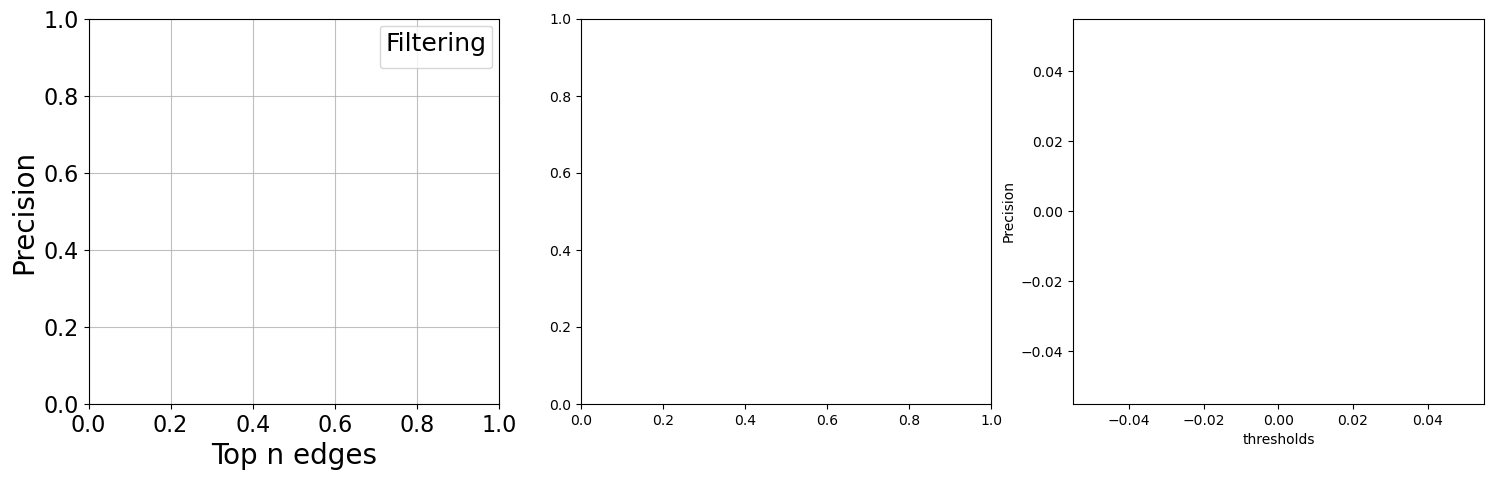

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
label_fontsize = 20

metrics = metrics_collector
# 1. Prepare the data: Create a combined hue column for differentiation
plot_data = metrics
plot_data['combined_hue'] = plot_data['comparison'] 

# 2. Set up the figure and axes (standard matplotlib way)
fig, (ax , ax2, ax3)= plt.subplots(1,3,figsize=(18, 5) ) # Adjust figure size as needed

# 3. Draw the single lineplot
line_plot = sns.lineplot(
    data=plot_data[plot_data['data_configuration'].isin(['5_sources'])],
    x='thresholds',
    y='Precision',
    hue='combined_hue',  # Use the combined column for the legend
    ax=ax,
    palette=sns.color_palette("rocket", 4), # Need more colors now (4 lines)
    linewidth=2,

)

# 3. Draw the single lineplot
line_plot = sns.lineplot(
    data=plot_data[plot_data['data_configuration'].isin(['10_sources'])],
    x='thresholds',
    y='Precision',
    hue='combined_hue',  # Use the combined column for the legend
    ax=ax2,
    palette=sns.color_palette("rocket", 4), # Need more colors now (4 lines)
    linewidth=2,

)

# 3. Draw the single lineplot
line_plot = sns.lineplot(
    data=plot_data[plot_data['data_configuration'].isin(['10_sources'])],
    x='thresholds',
    y='Precision',
    hue='combined_hue',  # Use the combined column for the legend
    ax=ax3,
    palette=sns.color_palette("rocket", 4), # Need more colors now (4 lines)
    linewidth=2,

)


# 4. Apply axis and style settings
ax.set_xlabel('Top n edges', fontsize=label_fontsize)
ax.set_ylabel('Precision', fontsize=label_fontsize)

ax.tick_params(axis='x', labelsize=label_fontsize - 4)
ax.tick_params(axis='y', labelsize=label_fontsize - 4)

# Apply custom y-axis formatter (assuming FuncFormatter(format_ticks) is defined)
try:
        formatter = FuncFormatter(format_ticks)
        ax.yaxis.set_major_formatter(formatter)
except NameError:
        print("Warning: FuncFormatter(format_ticks) is not defined. Skipping y-axis formatter.")
        pass # Skip if not defined

ax.grid(True, alpha=0.8)
#ax.set_xscale('log')

# 5. Legend placement and styling
# Get the legend handle
legend = ax.legend(title='Filtering', loc='upper right')

# Apply legend styling
plt.setp(legend.get_texts(), fontsize=label_fontsize - 4)
plt.setp(legend.get_title(), fontsize=label_fontsize - 2)

# 6. Save the figure as PDF

# Note: 'ax' is the equivalent of 'axs['A']' from your original code.
plt.show() # Use this to display the plot if running in a script

In [ ]:
line_plot.show()

AttributeError: 'Axes' object has no attribute 'show'

In [ ]:
plt.savefig('/data/bionets/og86asub/SignifiKANTE_Results/img/precision_synthetic.pdf')

<Axes: xlabel='thresholds', ylabel='jaccard_index'>

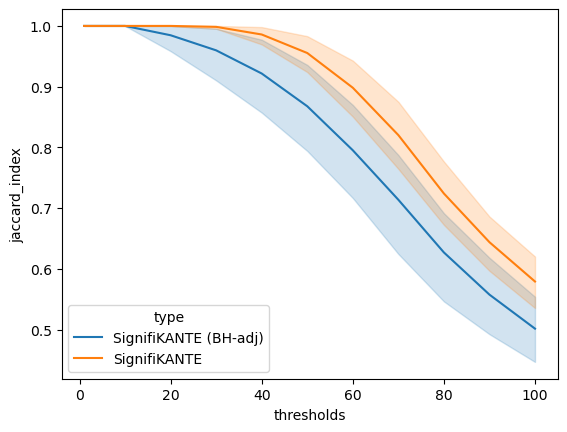

In [ ]:
sns.lineplot(myjac, x = 'thresholds', y='jaccard_index', hue = 'type')

In [ ]:
p_net_collect['5_sources'][2][p_net_collect['5_sources'][2].p_adj<0.05]

,Unnamed: 0,TF,target,importance,count,shuffled_occurences,pvalue,p_adj,edge_keys
0,5,L3MBTL1,SOX9,64.937,0.000,1000,0.001,0.008,L3MBTL1_SOX9
1,13,L3MBTL1,PCK2,57.435,0.000,1000,0.001,0.008,L3MBTL1_PCK2
2,29,SF1,MC2R,56.895,0.000,1000,0.001,0.008,SF1_MC2R
3,1,L3MBTL1,SF1,55.331,0.000,1000,0.001,0.008,L3MBTL1_SF1
4,0,ARNT2,CYP1A1,42.536,0.000,1000,0.001,0.008,ARNT2_CYP1A1
5,13,SF1,SOX9,40.660,0.000,1000,0.001,0.008,SF1_SOX9
6,12,L3MBTL1,MC2R,40.189,0.000,1000,0.001,0.008,L3MBTL1_MC2R
7,11,L3MBTL1,HSD3B2,40.014,0.000,1000,0.001,0.008,L3MBTL1_HSD3B2
8,17,SF1,SULT2A1,39.741,0.000,1000,0.001,0.008,SF1_SULT2A1
9,9,L3MBTL1,TGFB3,37.909,0.000,1000,0.001,0.008,L3MBTL1_TGFB3
